Pipeline based on titanic.csv dataset.

More comments right down below :)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore') 

In [2]:
dataset = pd.read_csv('titanic.csv')
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
X = dataset.drop(['Survived'], axis=1).copy()
y = dataset['Survived'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [4]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
])

In [5]:
#i am checking is there any missing data
#We can fit this Pipeline and then transform it on the training set

print('Raw dataset - train set:')
print(X_train[num_features].isnull().mean()) 
X_train_transformed = num_preparation.fit_transform(X_train[num_features])
X_train_transformed = pd.DataFrame(X_train_transformed, columns=num_features)
print('\nPipeline - train set')
print(X_train_transformed[num_features].isnull().mean())

Raw dataset - train set:
Age      0.196108
SibSp    0.000000
Parch    0.000000
Fare     0.000000
dtype: float64

Pipeline - train set
Age      0.0
SibSp    0.0
Parch    0.0
Fare     0.0
dtype: float64


In [6]:
#We have already ‘learned’ the Pipeline, now we can transform new data – such as the test set

print('Raw dataset - train set:')
print(X_test[num_features].isnull().mean())
X_test_transformed = num_preparation.transform(X_test[num_features])
X_test_transformed = pd.DataFrame(X_test_transformed, columns=num_features)
print('\nPipeline - train set')
print(X_test_transformed[num_features].isnull().mean())

Raw dataset - train set:
Age      0.206278
SibSp    0.000000
Parch    0.000000
Fare     0.000000
dtype: float64

Pipeline - train set
Age      0.0
SibSp    0.0
Parch    0.0
Fare     0.0
dtype: float64


In [7]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']

num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
])
#Fills in missing data in numeric columns using their average
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

In [8]:
data_preparation.fit_transform(X_train)

array([[35.    ,  1.    ,  0.    , 90.    ],
       [19.    ,  0.    ,  0.    , 10.5   ],
       [34.    ,  0.    ,  0.    , 13.    ],
       ...,
       [48.    ,  1.    ,  3.    , 34.375 ],
       [47.    ,  0.    ,  0.    , 38.5   ],
       [27.    ,  0.    ,  0.    ,  8.6625]])

In [9]:
#Let's create our own FilterName Transformer based on Custom Transformer.
#Our custom Transformer will extract the prefix from the Name column and treat all names other than 'Mr', 'Miss', 'Mrs' as 'Other'.

class Filter_Name(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        X_transformed = X.copy()
        column = self.column
        X_transformed[column] = X_transformed[column].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
        X_transformed.loc[~X_transformed[column].isin(['Mr', 'Miss', 'Mrs']), column] = 'Other'
        return X_transformed

In [10]:
#Let's check the Transformer operation for the 'Name' column in X_train.

transformer_filter_name = Filter_Name(column='Name')
display(X_train[['Name']])
display(transformer_filter_name.fit_transform(X_train[['Name']]))

,Name
486,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)"
238,"Pengelly, Mr. Frederick William"
722,"Gillespie, Mr. William Henry"
184,"Kink-Heilmann, Miss. Luise Gretchen"
56,"Rugg, Miss. Emily"
...,...
547,"Padro y Manent, Mr. Julian"
469,"Baclini, Miss. Helene Barbara"
736,"Ford, Mrs. Edward (Margaret Ann Watson)"
462,"Gee, Mr. Arthur H"


,Name
486,Mrs
238,Mr
722,Mr
184,Miss
56,Miss
...,...
547,Mr
469,Miss
736,Mrs
462,Mr


In [11]:
#Based on this Transformer we will create a Pipeline cat_preparation for categorical variables. 
#As variables we will use Name (passenger's name with prefix), Sex (gender) and Embarked (place from which passenger embarked)

cat_features = ['Name', 'Sex', 'Embarked']

cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name'))
])

In [12]:
print('Before')
display(X_train[cat_features])
print('After')
display(cat_preparation.fit_transform(X_train[cat_features]))

Before


,Name,Sex,Embarked
486,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)",female,S
238,"Pengelly, Mr. Frederick William",male,S
722,"Gillespie, Mr. William Henry",male,S
184,"Kink-Heilmann, Miss. Luise Gretchen",female,S
56,"Rugg, Miss. Emily",female,S
...,...,...,...
547,"Padro y Manent, Mr. Julian",male,C
469,"Baclini, Miss. Helene Barbara",female,C
736,"Ford, Mrs. Edward (Margaret Ann Watson)",female,S
462,"Gee, Mr. Arthur H",male,S


After


,Name,Sex,Embarked
486,Mrs,female,S
238,Mr,male,S
722,Mr,male,S
184,Miss,female,S
56,Miss,female,S
...,...,...,...
547,Mr,male,C
469,Miss,female,C
736,Mrs,female,S
462,Mr,male,S


In [13]:
#However, before we change the unique categories to binary variables (One Hot Encoder), we need to fill in the missing values. 
#Here we will use the most_frequent method, which is the most frequently occurring category

cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False ,handle_unknown='ignore'))
])
cat_preparation.fit_transform(X_train[cat_features])

array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [14]:
print(cat_preparation.fit_transform(X_train[cat_features]).shape)

(668, 9)


In [15]:
#It's time to connect both Pipelines and put them in data_preparation.

num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Name', 'Sex', 'Embarked']

num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
])

cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)
])

In [16]:
#Lets check if Pipeline works on X_train data.

data_preparation.fit_transform(X_train)

array([[35.,  1.,  0., ...,  0.,  0.,  1.],
       [19.,  0.,  0., ...,  0.,  0.,  1.],
       [34.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [48.,  1.,  3., ...,  0.,  0.,  1.],
       [47.,  0.,  0., ...,  0.,  0.,  1.],
       [27.,  0.,  0., ...,  0.,  0.,  1.]])

In [17]:
data_preparation.fit_transform(X_train).shape

(668, 13)

In [18]:
#As model we will use Logistic Regression.

num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Name', 'Sex', 'Embarked']

num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
])

cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)
])

model_pipeline_v1 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

In [19]:
model_pipeline_v1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('categorical_preprocessing',
                                                  Pipeline(steps=[('filter_name',
                                                                   Filter_Name(column='Name')),
                                                                  ('fill_missings',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Name', 'Sex',
                                                   'Embarked'])])),
                ('model', LogisticRegression(max_iter=10000))])

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       137
           1       0.75      0.72      0.73        86

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



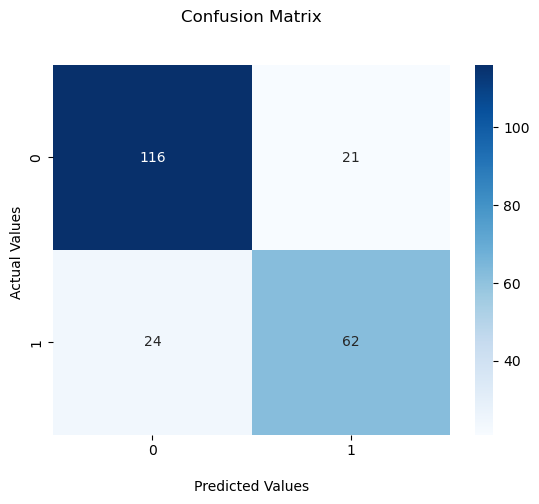

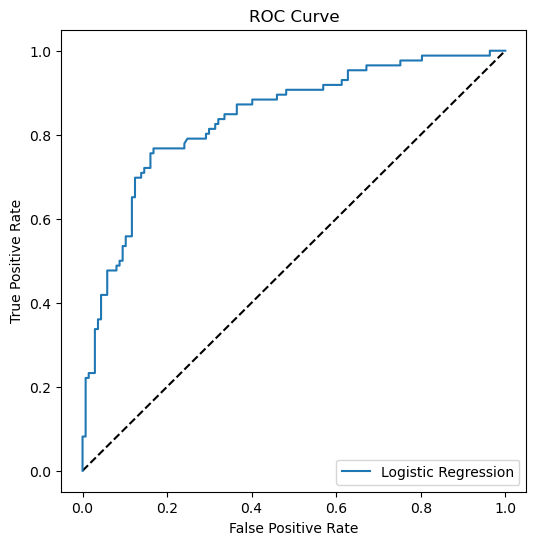

,Model,F1_score,AUC
0,Logistic Regression,0.733728,0.840477


In [22]:
#The model evaluation.

metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    print(classification_report(y_checked, predictions))

    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    new_row = pd.DataFrame({'Model': [name], 'F1_score': [f1_metric], 'AUC': [auc_metric]})
    metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)

    return metrics_dataframe

calculate_metrics(model_pipeline_v1, 'Logistic Regression', X_test, y_test)

However, our data is not fully prepared, we use a parametric model which is Logistic Regression, so it should receive scaled data. In addition, the dependencies can be non-linear for numerical variables. Therefore, we add a polynomial, then standardize the numerical variables. Is this the end? Not necessarily. Some of the variables will be correlated and will carry the same information, so we will use PCA - principal component analysis. After its result, the data does not have to be scaled, so the data should be standardized again

In [23]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Name', 'Sex', 'Embarked']

num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])

cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False ,handle_unknown='ignore'))
])

data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)
])

model_pipeline_v2 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
model_pipeline_v2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer()),
                                                                  ('polynomial_features',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('categorical_preprocessing',
                                                  Pipeline(steps=[('filter_name',
                                                                   Filter_Name(column='Name')),
                                                                  ('fill_missings',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Name', 'Sex',
                                                   'Embarked'])])),
                ('model', LogisticRegression(max_iter=10000))])

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       137
           1       0.75      0.76      0.75        86

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



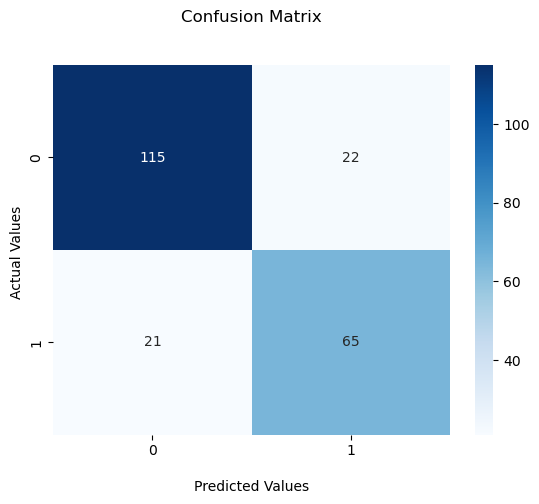

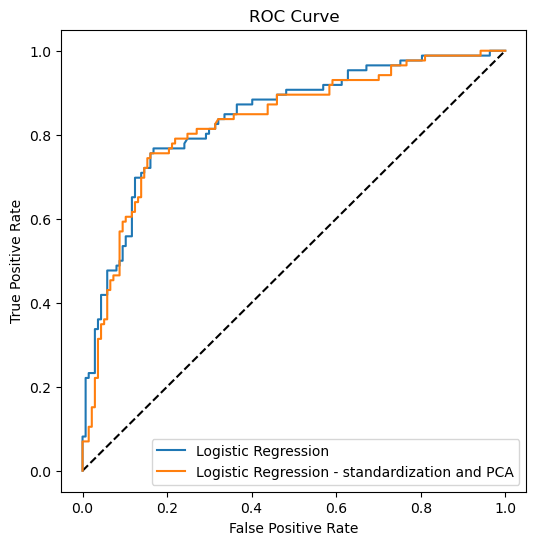

,Model,F1_score,AUC
0,Logistic Regression,0.733728,0.840477
1,Logistic Regression - standardization and PCA,0.751445,0.830207


In [24]:
calculate_metrics(model_pipeline_v2, 'Logistic Regression - standardization and PCA', X_test, y_test)

The results are very similar.

In [25]:
#The last model we will use will be like the previous one, but with a choice of hyperparameters.

model_pipeline_v3 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

In [26]:
#Referencing hyperparameters is not the same as before, so we need to get the names and references to them in our Pipeline.

list(model_pipeline_v3.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__numeric_preprocessing',
 'preprocessor__categorical_preprocessing',
 'preprocessor__numeric_preprocessing__memory',
 'preprocessor__numeric_preprocessing__steps',
 'preprocessor__numeric_preprocessing__verbose',
 'preprocessor__numeric_preprocessing__fill_missings',
 'preprocessor__numeric_preprocessing__polynomial_features',
 'preprocessor__numeric_preprocessing__scaler_1',
 'preprocessor__numeric_preprocessing__pca',
 'preprocessor__numeric_preprocessing__scaler_2',
 'preprocessor__numeric_preprocessing__fill_missings__add_indicator',
 'preprocessor__numeric_preprocessing__fill_missings__copy',
 'preprocessor__numeric_preprocessing__fill_missings__fill_value',
 'preprocessor__numeric_pr

In [27]:
#Lets make GridSerach to our model and train it.

params = {
    'preprocessor__numeric_preprocessing__fill_missings__strategy': ['mean', 'median'],
    'preprocessor__numeric_preprocessing__polynomial_features__degree': [1, 2, 3, 4],
    'preprocessor__numeric_preprocessing__pca__n_components': [0.85, 0.90, 0.95, 0.99, 0.99999],
    'model__C': np.logspace(-4, 4, 50)
}

grid_search = GridSearchCV(model_pipeline_v3, params, cv=10, n_jobs=-1, verbose=10, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Wybrane hiperparametry: ', grid_search.best_params_)
model_v3 = grid_search.best_estimator_

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
Wybrane hiperparametry:  {'model__C': 0.12648552168552957, 'preprocessor__numeric_preprocessing__fill_missings__strategy': 'mean', 'preprocessor__numeric_preprocessing__pca__n_components': 0.99, 'preprocessor__numeric_preprocessing__polynomial_features__degree': 3}


              precision    recall  f1-score   support

           0       0.83      0.85      0.84       137
           1       0.75      0.72      0.73        86

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



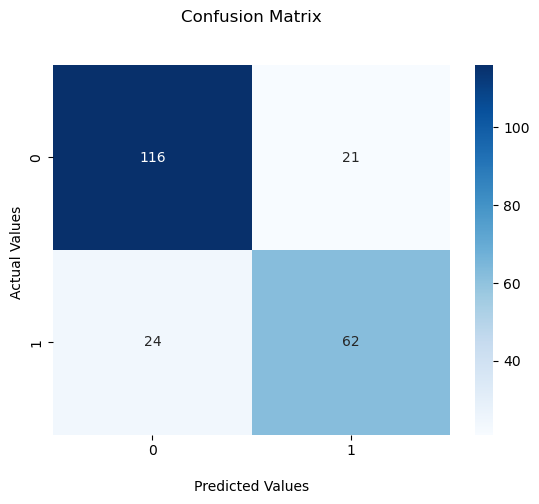

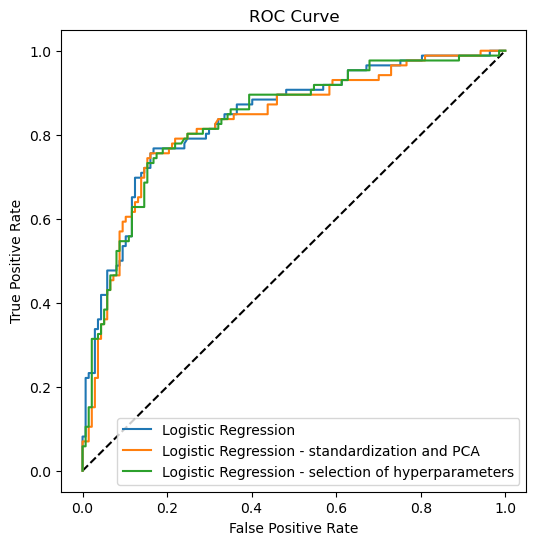

,Model,F1_score,AUC
0,Logistic Regression,0.733728,0.840477
1,Logistic Regression - standardization and PCA,0.751445,0.830207
2,Logistic Regression - selection of hyperparame...,0.733728,0.836403


In [28]:
calculate_metrics(model_v3, 'Logistic Regression - selection of hyperparameters', X_test, y_test)

The results are not significantly better, but this approach is the most desirable in machine learning - a Pipeline was created for data preparation and modeling, for which hyperparameters are then selected, based on validation sets.